# 📌 Projeto: Mottu SmartPark — Monitoramento IoT de Motos em Pátios

Este projeto tem como objetivo **simular e validar um sistema IoT de monitoramento de motos** nos pátios da Mottu, utilizando **tecnologia UWB (Ultra-Wideband)** para rastreamento em tempo real.

A ideia central é criar um **protótipo simulado** que gera dados de sensores (anchors e tags), processa esses dados para calcular as posições `(x, y)` das motos e associa essas posições às **vagas do pátio** (ex.: `A01`, `B05`).  

## 🎯 Objetivos principais
- Desenvolver um **protótipo funcional simulado** de leitura e processamento de dados IoT.  
- Implementar **algoritmos de trilateração** para cálculo de posição.  
- Identificar **vagas ocupadas vs. vagas livres** com base na posição das motos.  
- Criar **visualizações gráficas** do pátio, mostrando motos, vagas e anchors.  
- Exportar relatórios (CSV) com informações de ocupação.  

## 🏗️ Componentes simulados
- **Anchors (UWB fixos)**: usados para calcular distâncias até as motos.  
- **Tags (UWB móveis)**: instaladas em cada moto.  
- **Servidor local**: processa trilateração, aplica regras de negócio e envia dados para dashboard.  
- **Dashboard / visualização**: exibe pátio, motos e métricas em tempo real.  

## 🔎 Benefícios esperados
- Aumento da **produtividade operacional** no controle de pátios.  
- Redução de **erros humanos** na localização das motos.  
- Detecção de **eventos anômalos** (moto na vaga errada, desaparecimento, ocorrência etc.).  
- **Base técnica** para integração futura com visão computacional ou alertas automáticos.  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [2]:
# lê o arquivo separado por tab
df = pd.read_csv("Patio_Challenge.txt", sep="\t")

In [3]:
# salva como CSV separado por vírgula
df.to_csv("Patio_Challenge.csv", index=False)

In [4]:
df.head()

,tag_id,timestamp,anchor_id,tof_ns,distance_m,pos_x,pos_y,pos_confidence_pct,status
0,TAG_001,2025-01-01T08:00:01Z,A01,10.62285,3.18465,1.912,2.291,88.12,parado
1,TAG_001,2025-01-01T08:00:01Z,A02,127.10600,38.10543,1.912,2.291,88.12,parado
2,TAG_001,2025-01-01T08:00:01Z,A03,72.66587,21.78468,1.912,2.291,88.12,parado
3,TAG_001,2025-01-01T08:00:01Z,A04,146.41070,43.89282,1.912,2.291,88.12,parado
4,TAG_001,2025-01-01T08:00:01Z,A05,32.73001,9.81221,1.912,2.291,88.12,parado


In [5]:
# mostra o tipo de cada feature
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   tag_id              96 non-null     object 
 1   timestamp           96 non-null     object 
 2   anchor_id           96 non-null     object 
 3   tof_ns              96 non-null     float64
 4   distance_m          96 non-null     float64
 5   pos_x               96 non-null     float64
 6   pos_y               96 non-null     float64
 7   pos_confidence_pct  96 non-null     float64
 8   status              96 non-null     object 
dtypes: float64(5), object(4)
memory usage: 6.9+ KB


In [11]:
# pegar posição estimada por tag (cada tag repetida por anchor; as pos_x,pos_y são iguais, já que precisam de 8 sensores para delimitar onde devem estar)
df_tag = df.groupby("tag_id").first().reset_index()

In [12]:
# exibindo apenas as motos sem repetição
df_tag.head()

,tag_id,timestamp,anchor_id,tof_ns,distance_m,pos_x,pos_y,pos_confidence_pct,status
0,TAG_001,2025-01-01T08:00:01Z,A01,10.62285,3.184650,1.912,2.291,88.12,parado
1,TAG_002,2025-01-01T08:00:02Z,A01,20.92536,6.273265,3.075,5.428,65.61,parado
2,TAG_003,2025-01-01T08:00:03Z,A01,31.17043,9.344659,4.207,8.342,86.23,parado
3,TAG_004,2025-01-01T08:00:04Z,A01,41.59857,12.470940,5.185,11.302,87.23,parado
4,TAG_005,2025-01-01T08:00:05Z,A01,51.61958,15.475160,6.473,14.232,92.61,parado


In [13]:
# posições onde os anchors estão
anchors = np.array([
    [0.0, 0.0],
    [40.0, 0.0],
    [0.0, 24.0],
    [40.0, 24.0],
    [0.0, 12.0],
    [40.0, 12.0],
    [20.0, 0.0],
    [20.0, 24.0]
])


slot_width, slot_height = 1.1, 2.0   # definindo o tamando das vagas (tamanho real em metros)
rows, cols = 7, 34   # 7 fileiras com 34 vagas
start_x, start_y = 1.4, 1.4   # delimitando as margens
spacing_x, spacing_y = 0.0, 1.0   # espaçamento das vagas
letras = ["A","B","C","D","E","F","G"]   # como escolhemos denominar cada vaga

In [14]:
# --- cria DataFrame com todas as vagas do pátio ---
ocupacao_data = []

# percorre cada linha (fileira) e cada coluna (posição dentro da fileira)
for r in range(rows):          # rows = número de fileiras (ex: 7 → A..G)
    for c in range(cols):      # cols = número de vagas por fileira (ex: 34 → A01..A34)
        
        # calcula a posição (x, y) do canto inferior esquerdo da vaga
        x = start_x + c * (slot_width + spacing_x)
        y = start_y + r * (slot_height + spacing_y)
        
        # cria um identificador para a vaga (ex: A01, A02, ..., B01, ..., G34)
        vaga_id = f"{letras[r]}{c+1:02d}"
        
        # guarda as informações dessa vaga em uma lista
        ocupacao_data.append([vaga_id, x, y, df_tag["pos_confidence_pct"], df_tag["status"]])

# transforma a lista em DataFrame com colunas organizadas
df_ocupacao = pd.DataFrame(ocupacao_data, columns=["vaga_id", "x", "y","pos_confidence_pct", "status"])

# adiciona colunas de controle: se a vaga está ocupada e qual moto (tag_id) está nela
df_ocupacao["ocupada"] = False
df_ocupacao["tag_id"] = None


In [15]:
# --- gera df_tag a partir do df que você já tem ---
# usa média das posições por tag para evitar escolher sempre a mesma medição
df_tag = df.groupby("tag_id", as_index=False).agg({
    "pos_x": "mean",
    "pos_y": "mean"
})

In [16]:
# --- para cada moto (tag), encontrar a vaga mais próxima ---
for _, moto in df_tag.iterrows():
    
    # calcula a distância entre a posição da moto (pos_x, pos_y)
    # e o centro de cada vaga (x + metade da largura, y + metade da altura).
    centers_x = df_ocupacao["x"] + slot_width / 2
    centers_y = df_ocupacao["y"] + slot_height / 2
    dists = np.sqrt((centers_x - moto["pos_x"])**2 + (centers_y - moto["pos_y"])**2)
    
    # ordena as vagas por distância (da mais próxima para a mais distante).
    candidates = dists.argsort()
    assigned_idx = None
    
    # percorre as vagas em ordem de proximidade e pega a primeira que ainda esteja livre.
    for idx in candidates:
        if not df_ocupacao.at[idx, "ocupada"]:
            assigned_idx = idx
            break
    
    # se todas as vagas estiverem ocupadas (situação improvável, mas prevista),
    # a moto é associada mesmo assim à vaga mais próxima.
    if assigned_idx is None:
        assigned_idx = int(candidates[0])
    
    # marca a vaga como ocupada e registra o ID da moto que foi colocada nela.
    df_ocupacao.at[assigned_idx, "ocupada"] = True
    df_ocupacao.at[assigned_idx, "tag_id"] = moto["tag_id"]


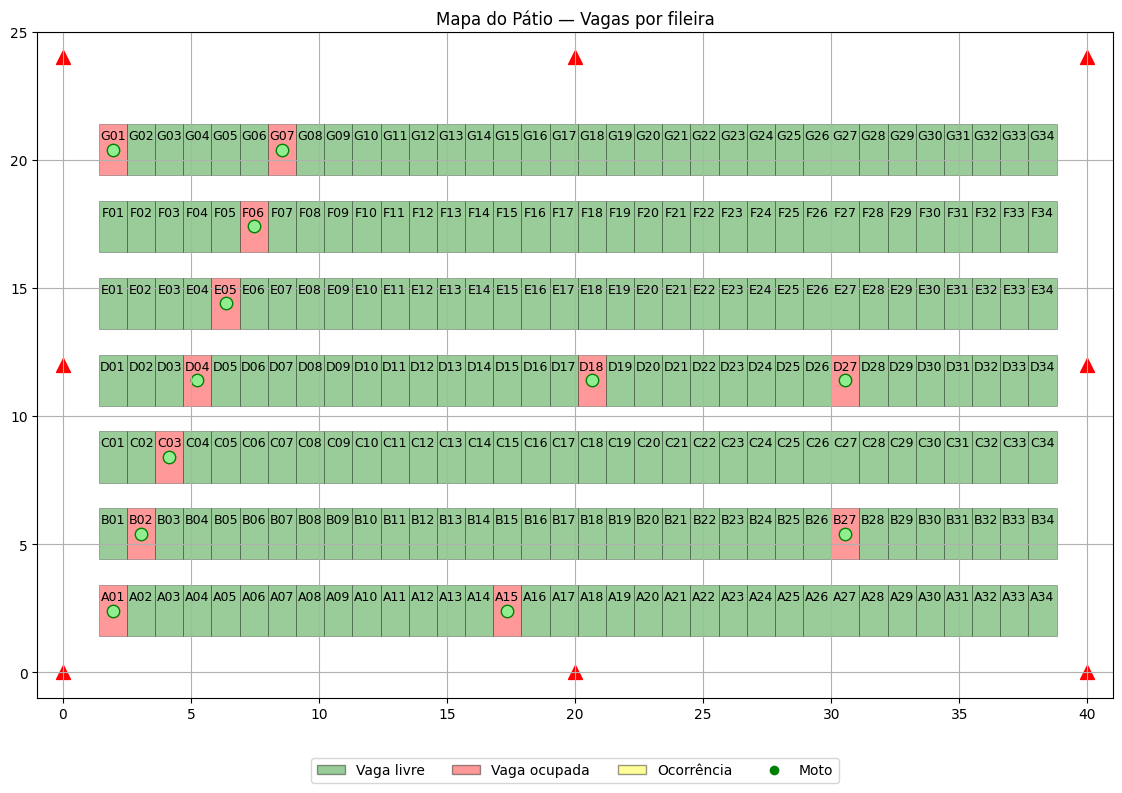


📋 Relatório de Ocupação e Ocorrências

✅ Vagas ocupadas:
vaga_id  tag_id
    A01 TAG_001
    A15 TAG_011
    B02 TAG_002
    B27 TAG_012
    C03 TAG_003
    D04 TAG_004
    D18 TAG_008
    D27 TAG_009
    E05 TAG_005
    F06 TAG_006
    G01 TAG_010
    G07 TAG_007


In [17]:
# --- criação do gráfico ---
def plot_patio(df_ocupacao):
    fig, ax = plt.subplots(figsize=(16,8))
    
    # plota os anchors
    ax.scatter(anchors[:,0], anchors[:,1], marker='^', color='red', s=100, label='Anchors')
    
    # para cada vaga no DataFrame, desenha um retângulo representando a vaga
    for _, row in df_ocupacao.iterrows():
        # verifica quantas motos tem nessa vaga
        if isinstance(row["tag_id"], list) and len(row["tag_id"]) > 1:
            color = 'yellow'   # ocorrência (duas ou mais motos)
        elif row["ocupada"]:
            color = 'red'      # ocupada normal
        else:
            color = 'green'    # vaga livre
        
        # desenha o retângulo da vaga
        rect = plt.Rectangle(
            (row["x"], row["y"]),          # canto inferior esquerdo
            slot_width, slot_height,       # largura e altura
            facecolor=color,
            alpha=0.4,
            edgecolor="black", linewidth=0.5
        )
        ax.add_patch(rect)
    
        # escreve o ID da vaga no topo da vaga
        ax.text(row["x"] + slot_width/2, row["y"] + slot_height - 0.2,
                row["vaga_id"], ha="center", va="top", fontsize=9, color="black")
    
    # destaca as motos: pontos pretos nos centros das vagas ocupadas
    df_motos = df_ocupacao[df_ocupacao["ocupada"]]
    ax.scatter(df_motos["x"] + slot_width/2, df_motos["y"] + slot_height/2,
               c="lightgreen", edgecolor='green', marker="o", s=80, label="Motos")
    
    # --- ajustes do gráfico ---
    x_max = start_x + cols * (slot_width + spacing_x)
    y_max = start_y + rows * (slot_height + spacing_y)
    ax.set_xlim(-1, max(41, x_max + 1))
    ax.set_ylim(-1, max(25, y_max + 1))
    ax.set_aspect('equal')
    ax.set_title("Mapa do Pátio — Vagas por fileira")
    
    # cria a legenda com a nova categoria "Ocorrência"
    legend_elements = [
        Patch(facecolor='green', edgecolor='black', label='Vaga livre', alpha=0.4),
        Patch(facecolor='red', edgecolor='black', label='Vaga ocupada', alpha=0.4),
        Patch(facecolor='yellow', edgecolor='black', label='Ocorrência', alpha=0.4),
        Line2D([0],[0], marker='o', color='w', label='Moto',
               markerfacecolor='green', markersize=8)
    ]
    ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5,-0.08), ncol=4)
    
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # --- mostrar na saída do console ---
    print("\n📋 Relatório de Ocupação e Ocorrências\n")
    ocupadas = df_ocupacao[df_ocupacao["ocupada"]].reset_index(drop=True)
    print("✅ Vagas ocupadas:")
    print(ocupadas[["vaga_id", "tag_id"]].to_string(index=False))
    
    ocorrencias = ocupadas[ocupadas["tag_id"].apply(lambda x: isinstance(x, list) and len(x) > 1)]
    if not ocorrencias.empty:
        print("\n⚠️ Ocorrências detectadas (mais de uma moto na mesma vaga):")
        print(ocorrencias[["vaga_id", "tag_id"]].to_string(index=False))

plot_patio(df_ocupacao)



---
# 📖 SUA VEZ!!!

## Agora VOCÊ vai colocar uma moto de forma simulada.

##### Você colocará uma moto de forma simulada numa simulação, duas camadas de simulação já kkkkkk


### 🛠️ Tudo o que você precisa fazer é seguir as instruções

##### Sabemos que as colunas (features) que regem esse Dataframe são as seguintes:
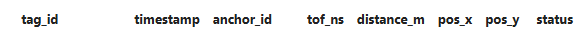

1. Escreva o seguinte código:

In [ ]:
# substitua pelo seguinte formato. Ex: "TAG_013", "2025-09-24 21:00:00", "A1", "24.2046", "13.9583", "19.218", "5.104", "parado"
# lembre de verificar as coordenadas no gráfico acima para colocar uma moto numa vaga legítima
df.loc[len(df)] = [tag_id, timestamp, anchor_id, tof_ns, distance_m, pos_x, pos_y, status]

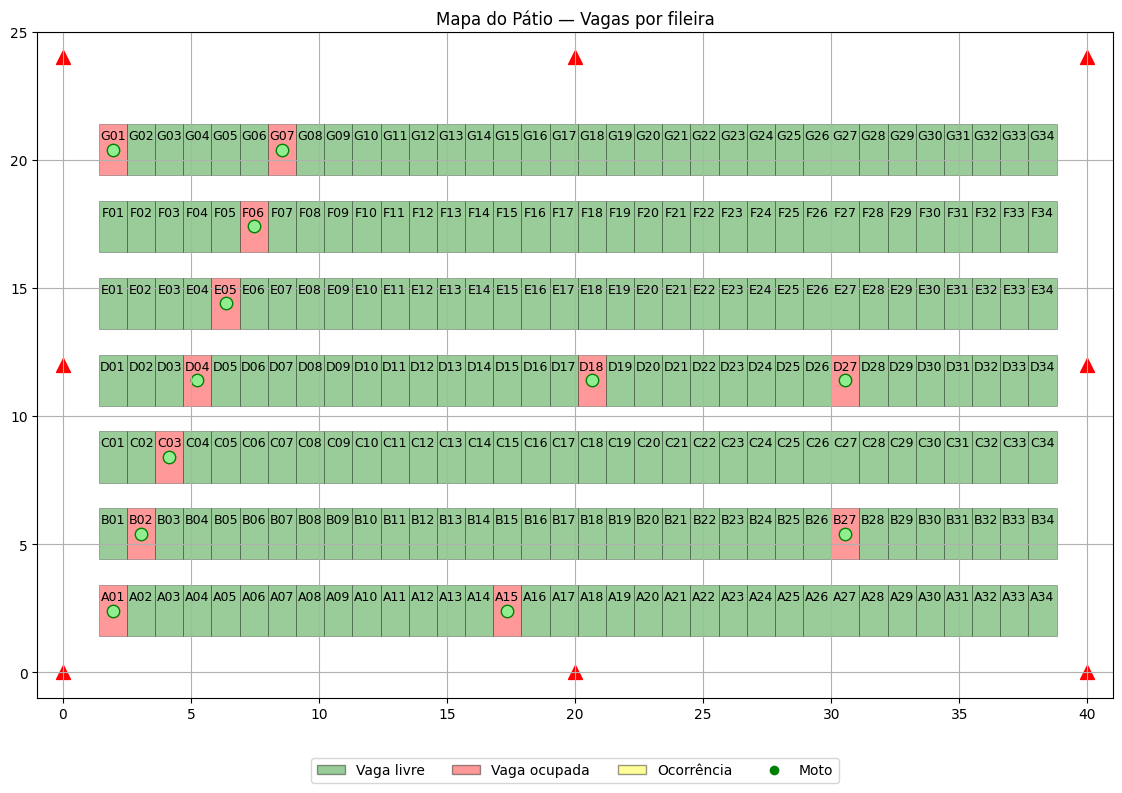


📋 Relatório de Ocupação e Ocorrências

✅ Vagas ocupadas:
vaga_id  tag_id
    A01 TAG_001
    A15 TAG_011
    B02 TAG_002
    B27 TAG_012
    C03 TAG_003
    D04 TAG_004
    D18 TAG_008
    D27 TAG_009
    E05 TAG_005
    F06 TAG_006
    G01 TAG_010
    G07 TAG_007


In [18]:
# visualizar a mudança no gráfico
plot_patio(df_ocupacao)



## Podemos visualizar a moto no lugar que você adicionou está presente no gráfico!!!

#### Agora caso queira editar e colocar aquela moto em outra vaga, aplique o seguinte código:

---

## 🏍️ Edição de Motos no Pátio

Depois de estruturarmos o **DataFrame `df_ocupacao`** para representar as vagas do pátio, também implementamos funcionalidades de **manutenção** das motos já posicionadas.  
Essas operações são úteis quando precisamos **atualizar a posição** de uma moto (editar a vaga) ou **removê-la** (quando ela sai do pátio).

### ✏️ Editar a posição de uma moto

Para editar a posição de uma moto já existente, utilizamos a função `mover_moto_por_coord`.  
Essa função recebe:

- `tag_id` → identificador único da moto (ex.: `"TAG_007"`).  
- `x, y` → novas coordenadas para a moto.  
- `force` → parâmetro opcional que, se `True`, força a moto a ocupar a nova vaga mesmo que já esteja ocupada, gerando uma **ocorrência**.

A lógica é: a função calcula a distância entre as coordenadas informadas e o centro de cada vaga, e associa a moto à **vaga mais próxima**.

In [19]:
# normaliza o conteúdo de uma célula da coluna 'tag_id' para:
# - None (vazio)
# - str (uma tag única)
# - list (uma lista de tags)
def _ensure_tag_list_cell(cell):
    if cell is None:
        return None  # célula vazia
    if isinstance(cell, list):
        return cell  # já é uma lista, retorna como está
    if isinstance(cell, str):
        s = cell.strip()  # remove espaços em branco extras
        return [s] if s != "" else None  # retorna lista de um elemento ou None se string vazia
    # trata casos de float NaN 
    try:
        import math
        if isinstance(cell, float) and math.isnan(cell):
            return None
    except:
        pass
    # fallback: transforma qualquer outro tipo em string única dentro de lista
    return [str(cell)]



In [20]:
# move ou adiciona uma moto (`tag_id`) para a vaga mais próxima das coordenadas (x, y).
# remove a moto da vaga antiga. Encontra a vaga mais próxima do ponto (x, y). Adiciona ou substitui a moto na nava nova
def mover_moto_por_coord(df_ocupacao, tag_id, x, y, force=False):
    # --- 0) garante que as coordenadas são floats ---
    x = float(x)
    y = float(y)

    # --- 1) normaliza coluna tag_id se necessário ---
    # Opcional: aplicar _ensure_tag_list_cell em toda coluna para evitar inconsistências
    # df_ocupacao["tag_id"] = df_ocupacao["tag_id"].apply(_ensure_tag_list_cell)

    # --- 2) remove a moto da vaga antiga (se estiver em alguma) ---
    # cria máscara para localizar células que contenham a tag_id
    mask_contains = df_ocupacao["tag_id"].apply(
        lambda t: (isinstance(t, list) and tag_id in t) or (isinstance(t, str) and t == tag_id)
    )
    idx_antigo = df_ocupacao[mask_contains].index

    if not idx_antigo.empty:
        idx_ant = idx_antigo[0]  # pega a primeira ocorrência (uma moto só)
        current = df_ocupacao.at[idx_ant, "tag_id"]
        
        # remove apenas a tag em questão
        if isinstance(current, list):
            if tag_id in current:
                current.remove(tag_id)
            if len(current) == 0:
                # lista vazia -> vaga livre
                df_ocupacao.at[idx_ant, "tag_id"] = None
                df_ocupacao.at[idx_ant, "ocupada"] = False
            else:
                df_ocupacao.at[idx_ant, "tag_id"] = current
                df_ocupacao.at[idx_ant, "ocupada"] = True
        elif isinstance(current, str):
            # única tag -> libera vaga
            df_ocupacao.at[idx_ant, "tag_id"] = None
            df_ocupacao.at[idx_ant, "ocupada"] = False
        else:
            # None/NaN -> garante vaga livre
            df_ocupacao.at[idx_ant, "tag_id"] = None
            df_ocupacao.at[idx_ant, "ocupada"] = False

    # --- 3) encontra a vaga mais próxima das coordenadas (x, y) ---
    centers_x = df_ocupacao["x"] + slot_width / 2  # centro horizontal da vaga
    centers_y = df_ocupacao["y"] + slot_height / 2  # centro vertical da vaga
    dists = np.sqrt((centers_x - x)**2 + (centers_y - y)**2)  # distância euclidiana
    idx_novo = dists.idxmin()  # índice da vaga mais próxima
    vaga_id = df_ocupacao.at[idx_novo, "vaga_id"]

    # --- 4) adiciona a moto na vaga nova ---
    existing = df_ocupacao.at[idx_novo, "tag_id"]

    if force:
        # sobrescreve todas as motos da vaga
        df_ocupacao.at[idx_novo, "tag_id"] = [tag_id]
        df_ocupacao.at[idx_novo, "ocupada"] = True
        print(f"⚠️ Force: vaga {vaga_id} agora contém somente {tag_id}.")
        return df_ocupacao

    # vaga vazia -> adiciona como lista de 1 elemento
    if existing is None:
        df_ocupacao.at[idx_novo, "tag_id"] = [tag_id]
        df_ocupacao.at[idx_novo, "ocupada"] = True
        print(f"✅ Moto {tag_id} adicionada na vaga {vaga_id} (vaga estava livre).")
        return df_ocupacao

    # se já existe uma moto como string -> transforma em lista
    if isinstance(existing, str):
        existing_list = [existing]
    elif isinstance(existing, list):
        existing_list = existing
    else:
        existing_list = []  # NaN ou outro tipo inesperado

    # adiciona a moto somente se ainda não estiver na vaga
    if tag_id in existing_list:
        print(f"ℹ️ Moto {tag_id} já estava presente na vaga {vaga_id}.")
    else:
        existing_list.append(tag_id)
        df_ocupacao.at[idx_novo, "tag_id"] = existing_list
        df_ocupacao.at[idx_novo, "ocupada"] = True
        print(f"✅ Moto {tag_id} adicionada na vaga {vaga_id} (agora {len(existing_list)} motos).")

    return df_ocupacao

In [ ]:
# agora aqui, você vai ter editar a "tag_id" no foramto "TAG_001" da moto e as coordenadas da vaga "x" e "y" no formato 12.34
df_ocupacao = mover_moto_por_coord(df_ocupacao, "TAG_007", 8.4, 20)

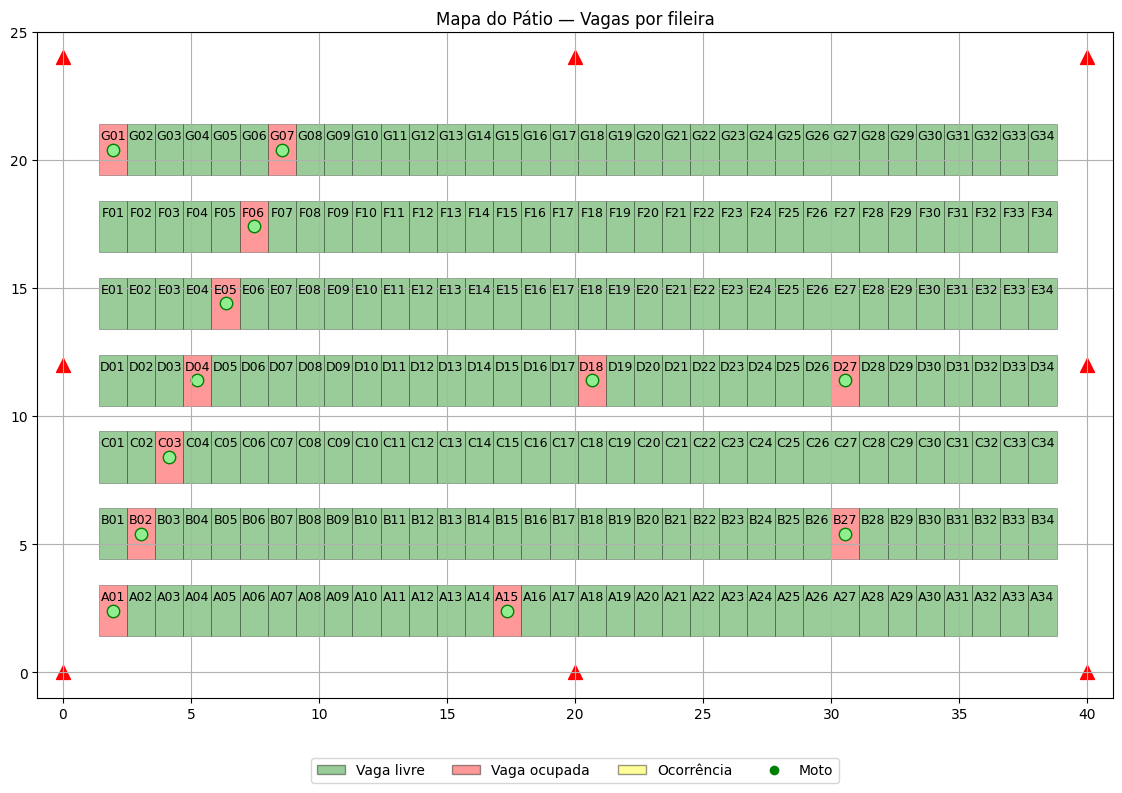


📋 Relatório de Ocupação e Ocorrências

✅ Vagas ocupadas:
vaga_id    tag_id
    A01 [TAG_001]
    A15   TAG_011
    B02   TAG_002
    B27   TAG_012
    C03   TAG_003
    D04   TAG_004
    D18   TAG_008
    D27   TAG_009
    E05   TAG_005
    F06   TAG_006
    G01   TAG_010
    G07 [TAG_007]


In [24]:
# aplicando novamente o gráfico do pátio para visualização
plot_patio(df_ocupacao)

# Acabamos de visualizar ela sendo trocada de posição, mas além disso, também podem os remover ela do patio

---

# 🗑️ Remover uma moto do pátio

Se uma moto precisa ser retirada, utilizamos a função remover_moto.
Ela localiza a vaga associada ao tag_id informado e a libera, marcando-a como livre novamente.

Isso se resume a moto que não é mais considerada no sistema ou apenas foi **removida** do pátio (quando ela sai do pátio)

In [135]:
# remoce uma moto do pátio, liberando vaga correspondente
# caso tenha uma moto com essa tag ele libera a vaga, caso não, ele apenas diz que a moto não está naquele pátio
def remover_moto(df_ocupacao, tag_id):
    # --- 1) localiza a vaga que contém a moto ---
    idx = df_ocupacao[df_ocupacao["tag_id"] == tag_id].index

    if not idx.empty:
        # --- 2) remove a moto e libera a vaga ---
        vaga_id = df_ocupacao.at[idx[0], "vaga_id"]  # pega o id da vaga
        df_ocupacao.at[idx[0], "ocupada"] = False   # marca como vaga livre
        df_ocupacao.at[idx[0], "tag_id"] = None     # remove a moto
        print(f"✅ Moto {tag_id} removida da vaga {vaga_id}.")
    else:
        # --- 3) caso a moto não esteja no pátio ---
        print(f"❌ Moto {tag_id} não encontrada no pátio.")
    
    return df_ocupacao  # retorna DataFrame atualizado


In [ ]:
# Aqui é do mesmo jeito que os outros, substitua somente a "tag_id" por uma tag no formato "TAG_001"
remover_moto(df_ocupacao, tag_id)

## 📌 Conclusão

O aprendizado de máquina aplicado neste projeto mostrou-se uma ferramenta viável para **mapear, organizar e monitorar motos em pátios operacionais**. A utilização de dados de ancoragem (anchors), cálculo de posição e confiança de localização (`pos_confidence_pct`) permitiu não apenas identificar em tempo real quais vagas estão ocupadas, mas também verificar a **qualidade da predição da posição** de cada veículo.  

### Benefícios observados:
- ✅ **Redução de erros humanos** no controle de pátios.  
- ✅ **Otimização do tempo de operação**, já que a localização das motos pode ser identificada de forma automatizada.  
- ✅ **Melhoria da experiência operacional** para administradores, que passam a contar com um sistema de visualização simples e preciso.  
- ✅ **Base para decisões estratégicas**, como ajustes no layout do pátio, cálculo de ocupação média e até previsões de demanda.  

Apesar dos resultados parciais positivos, é importante destacar que a acurácia do modelo depende da **qualidade dos sensores e da densidade das ancoragens**. Em etapas futuras, técnicas de **aprendizado supervisionado** poderão ser utilizadas para aumentar a confiabilidade na detecção de anomalias, como motos em vagas incorretas ou leituras inconsistentes de posição.  

---

Em resumo, o aprendizado de máquina aplicado neste projeto representa um **passo relevante para a automação inteligente da gestão de frotas**, trazendo ganhos de **eficiência, segurança e escalabilidade** para a operação da Mottu.  
